# MD Simulations of NTRKs

This notebook analyses results from MD simulations of inhibitors larotrectinib, selitrectinib and repotrectinib docked into NTRK1-3.

## 1. System preparation

## 1.1 Docked structures

#### Data can be found in `../docking/docking.ipynb`

PDB structures `4YNE`, `4AT3`, and `6KZD` were used as structures for NTRK1, NTRK2, and NTRK3 respectively. 

A short summary of how structures were produced is shown below (check `../docking/docking.ipynb` for a full description):

* NTRK structures for docking were chosen based on searching the KLIFS database for NTRK entries in complex with ligands similar to the core structure of larotrectinib.
* Both `4YNE` and `4AT3` are in the DFG in/$\alpha$C helix out conformation, whilst `6KZD` is in the DFG out/$\alpha$C helix out conformation.
* OESpruce was not able to model all missing residues.
* Docking results were good for NTRK1 and NTRK2 compared to binding modes in Figure 1 from [Drilon et al. 2017](https://cancerdiscovery.aacrjournals.org/content/7/9/963).
* Docking into NTRK3 in the wrong conformation gave worse results. Another approach was performed using the coordinates of the nitrogen atom named NAN of the co-crystalized ligand in `6KZD` as hint coordinates for chemgauss docking. 

## 1.2 Adding missing residues

#### Data can be found in: `./data/add_missing_loops/`

All models created via docking contained missing loop residues that were not modelled by OESpruce.

* `4YNE` contained 4 missing loops (between 2-5 residues missing in each loop).
* `4AT3` contained 4 missing loops (between 2-4 residues missing in each loop).
* `6KZD` contained 2 missing loops (between 12-16 residues missing in each loop).

[MODELLER](https://salilab.org/modeller/) was used to add in the short loops in both `4YNE` and `4AT3`. Since `6KZD` contained two large loops (12 and 16 residues respoectively) loops were not modelled in.

Alignment files were manually created using the full protein sequence and PDB file sequence (extracted via [PyMol](https://pymol.org/2/)). Any artifacts (e.g. the expression tag `GSGIR` in `4YNE`) were from the structural sequence before creating models.

A total of 200 models were created and scored using [Discret Optimised Protein Energy](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2242414/) (DOPE). The best scoring DOPE models (most negative value) for each strcuture were:

* `4YNE`: 4YNE_fill.BL01040001.pdb (DOPE score -4225.328)
* `4AT3`: 4AT3_fill.BL00850001.pdb (DOPE score -3242.686)
* `6KZD`: N/A

## 1.3 Equilibration

#### Data can be found in: `./data/md_equil/`

All models were capped with ACE and NME residues at their N and C termini. `TER` cards were added at the end of each chain and the final model saved as: `<pdb_code>_prepped.pdb` (e.g. `./data/md_equil/4YNE/4YNE_prepped.pdb`).

The equilibration protocol for each system can be found in `./data/md_equil/<pdb_code>/md_equil.py`. A general overview is given below:

* Each protein:ligand system was prepared using the `amberff14sb`:`openff-1.1.0` forcefields and energy minimised.
* Temperature = 300 K, Pressure = 1 bar, Ionic strength = 150 mM NaCl. 
* Each system was equilibrated in the NPT ensemble for 5 ns.
* The final equilibrated structure was written out to a PDB file named `equilibrated_state_5ns.pdb` (e.g. `./data/md_equil/output/larotrectinib/equilibrated_state_5ns.pdb`) for visual inspection.



## 2. Production runs

In [1]:
import MDAnalysis as mda
import MDAnalysis.analysis.rms
import MDAnalysis.transformations as trans
import matplotlib.pyplot as plt
import nglview as nv
import numpy as np

In [2]:
# Define some functions to use in the notebook

def centre_protein(dict_of_systs, wrap=False):
    
    # Centre the protein in the box using MDAnalysis
    for syst in dict_of_systs:
        u = dict_of_systs[syst]
        reference = u.copy().select_atoms('protein or resname ACE NME')

        protein = u.select_atoms('protein or resname ACE NME')
        not_protein = u.select_atoms('not protein')

        transforms = [trans.center_in_box(protein, wrap=wrap, center="geometry"),
                  trans.wrap(not_protein),
                  trans.fit_rot_trans(protein, reference)
                     ]

        dict_of_systs[syst].trajectory.add_transformations(*transforms)
        
    return dict_of_systs
    
    
def delta_cog_inhib(name, dict_of_systs):

    # Calculate the distance changes between the original docked ligand's centre of geometry 
    # and the centre of geometry at each frame

    inhib_resnames = ['resname lar', 'resname sel', 'resname rep']
    inhib_store = {'larotrectinib': {'time' : [], 'cog': []},
                        'selitrectinib': {'time' : [], 'cog': []},
                        'repotrectinib': {'time' : [], 'cog': []}}

    for sel, syst in zip(inhib_resnames, dict_of_systs):
        
        print("current system: " + syst)

        u = dict_of_systs[syst]
        u.trajectory[0]

        inhib_sel = u.select_atoms(sel)
        ref_cog = inhib_sel.center_of_geometry()

        for ts in u.trajectory:

            inhib_store[syst]['time'].append(ts.time / 1000)

            dist = np.linalg.norm(inhib_sel.center_of_geometry() - ref_cog)

            inhib_store[syst]['cog'].append(dist)

    # Plot
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    cb_colour_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                      '#f781bf', '#a65628', '#984ea3',
                      '#999999', '#e41a1c', '#dede00']
    i=0

    for sel, syst in zip(inhib_resnames, dict_of_systs):
        i+=1

        cog = inhib_store[syst]['cog']
        time = inhib_store[syst]['time']
        ax.plot(time, cog, cb_colour_cycle[i], label=name + ":" + syst, alpha=0.8)
        ax.legend(loc="best")
        ax.set_xlabel("Time (ns)")
        ax.set_ylabel(r'$\Delta$ Distance ($\AA$)')


def calc_rmsd(name, dict_of_systs):
    
    rmsd_store = []

    for syst in dict_of_systs:
        print("Calculating RMSD for " + name + ":" + syst)

        # Load system and reset trajectory to the first frame
        u = dict_of_systs[syst]
        u.trajectory[0]
        ref = u

        R = MDAnalysis.analysis.rms.RMSD(u, ref,
                   select="backbone",             # superimpose on whole backbone of the whole protein
                   groupselections=["backbone"])   # whole protein

        #"backbone and resid 554-566" # C-Helix
        #"backbone and resid 668-670" # DFG motif                       
        #"backbone and resid 517-522" # Glycine loop
        #"backbone and resid 544-560" # Conserved lysine, glutamate
        #"backbone and resid 648-650" # HRD motif 
        #"backbone and resid 668-694" # Activation loop

        R.run()
        rmsd_store.append(R)

    # Plot the RMSDs
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    cb_colour_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                      '#f781bf', '#a65628', '#984ea3',
                      '#999999', '#e41a1c', '#dede00']

    for i, syst in enumerate(dict_of_systs):

        rmsd = rmsd_store[i].rmsd.T   # transpose makes it easier for plotting
        time = rmsd[1] / 1000
        ax.plot(time, rmsd[2], cb_colour_cycle[i], label=name + ":" + syst, alpha=0.8)
        ax.legend(loc="best")
        ax.set_xlabel("Time (ns)")
        ax.set_ylabel(r"RMSD ($\AA$)")

## 2.1 4YNE (NTRK1)

In [3]:
# Note: if the trajectory is not available only load the .pdb files
# trajectories have not been uploaded to the repo due to their size
ntrk1_systems = {'larotrectinib': mda.Universe(
    "./data/md_equil/4YNE/output/larotrectinib/equilibrated_state_5ns.pdb",
    "./data/md_production_run/4YNE/output/larotrectinib/pr_output_traj.xtc"),
                'selitrectinib': mda.Universe(
    "./data/md_equil/4YNE/output/selitrectinib/equilibrated_state_5ns.pdb",
    "./data/md_production_run/4YNE/output/selitrectinib/pr_output_traj.xtc"),
                'repotrectinib': mda.Universe(
    "./data/md_equil/4YNE/output/repotrectinib/equilibrated_state_5ns.pdb",
    "./data/md_production_run/4YNE/output/repotrectinib/pr_output_traj.xtc")}

ntrk1_systems_cent = centre_protein(ntrk1_systems)

In [4]:
view = nv.show_mdanalysis(ntrk1_systems_cent['larotrectinib'])
view.center()
# View with nglview
view

NGLWidget(max_frame=1642)

In [5]:
view = nv.show_mdanalysis(ntrk1_systems_cent['selitrectinib'])
view.center()
# View with nglview
view


NGLWidget(max_frame=1752)

In [6]:
view = nv.show_mdanalysis(ntrk1_systems_cent['repotrectinib'])
view.center()
# View with nglview
view

NGLWidget(max_frame=1711)

Calculating RMSD for 4YNE:larotrectinib
Calculating RMSD for 4YNE:selitrectinib
Calculating RMSD for 4YNE:repotrectinib


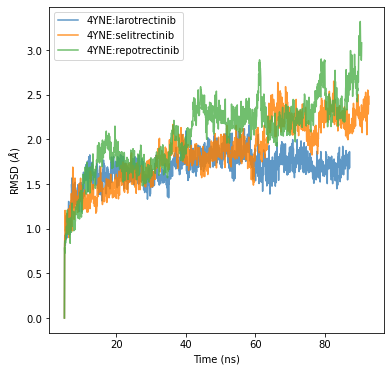

In [7]:
calc_rmsd('4YNE', ntrk1_systems_cent)

current system: larotrectinib
current system: selitrectinib
current system: repotrectinib


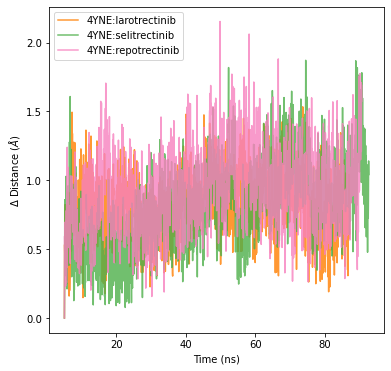

In [8]:
# Looking at how much the inhibtor's centre of geometry moves from the original docked pose
delta_cog_inhib('4YNE', ntrk1_systems_cent)

## 2.2 4AT3 (NTRK2)

In [9]:
# Note: if the trajectory is not available only load the .pdb files
# trajectories have not been uploaded to the repo due to their size
ntrk2_systems = {'larotrectinib': mda.Universe(
    "./data/md_equil/4AT3/output/larotrectinib/equilibrated_state_5ns.pdb",
    "./data/md_production_run/4AT3/output/larotrectinib/pr_output_traj.xtc"),
                'selitrectinib': mda.Universe(
    "./data/md_equil/4AT3/output/selitrectinib/equilibrated_state_5ns.pdb",
    "./data/md_production_run/4AT3/output/selitrectinib/pr_output_traj.xtc"),
                'repotrectinib': mda.Universe(
    "./data/md_equil/4AT3/output/repotrectinib/equilibrated_state_5ns.pdb",
    "./data/md_production_run/4AT3/output/repotrectinib/pr_output_traj.xtc")}

ntrk2_systems_cent = centre_protein(ntrk2_systems)

In [10]:
view = nv.show_mdanalysis(ntrk2_systems_cent['larotrectinib'])
view.center()
# View with nglview
view

NGLWidget(max_frame=2903)

In [11]:
view = nv.show_mdanalysis(ntrk2_systems_cent['selitrectinib'])
view.center()
# View with nglview
view

NGLWidget(max_frame=2922)

In [12]:
view = nv.show_mdanalysis(ntrk2_systems_cent['repotrectinib'])
view.center()
# View with nglview
view

NGLWidget(max_frame=3034)

Calculating RMSD for 4AT3:larotrectinib
Calculating RMSD for 4AT3:selitrectinib
Calculating RMSD for 4AT3:repotrectinib


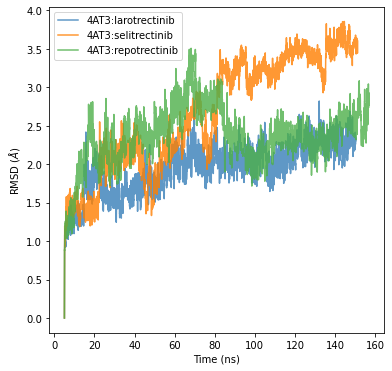

In [13]:
calc_rmsd('4AT3', ntrk2_systems_cent)

current system: larotrectinib
current system: selitrectinib
current system: repotrectinib


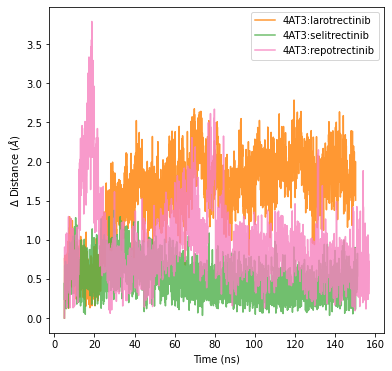

In [14]:
# Looking at how much the inhibtor's centre of geometry moves from the original docked pose
delta_cog_inhib('4AT3', ntrk2_systems_cent)

## 2.3 6KZD (NTRK3)

In [15]:
# FIXME: Need to centre both chains in 6KZD

# Note: if the trajectory is not available only load the .pdb files
# trajectories have not been uploaded to the repo due to their size
ntrk3_systems = {'larotrectinib': mda.Universe(
    "./data/md_equil/6KZD/output/larotrectinib/equilibrated_state_5ns.pdb",
    "./data/md_production_run/6KZD/output/larotrectinib/pr_output_traj.xtc"),
                'selitrectinib': mda.Universe(
    "./data/md_equil/6KZD/output/selitrectinib/equilibrated_state_5ns.pdb",
    "./data/md_production_run/6KZD/output/selitrectinib/pr_output_traj.xtc"),
                'repotrectinib': mda.Universe(
    "./data/md_equil/6KZD/output/repotrectinib/equilibrated_state_5ns.pdb",
    "./data/md_production_run/6KZD/output/repotrectinib/pr_output_traj.xtc")}

ntrk3_systems_cent = centre_protein(ntrk3_systems, wrap=False)